- medium: https://medium.com/@vineet.mundhra/loading-bert-with-tensorflow-hub-7f5a1c722565
- notebook: https://github.com/vineetm/tfhub-bert/blob/master/bert_tfhub.ipynb

In [3]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [4]:
%load_ext autoreload
%autoreload 2

## Labels

In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"
stocks = ["TSLA", "BTC-USD"]
keywords = {"TSLA": ["Tesla", "Elon Musk"],
            "BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df_financial = df_financial["Close"]

In [6]:
import matplotlib
matplotlib.__version__

'3.2.1'

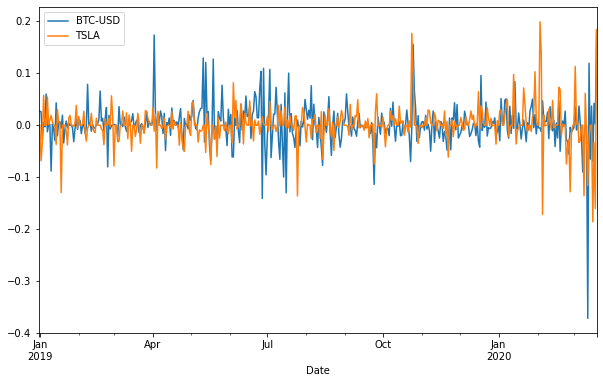

In [7]:
df_returns = df_financial.pct_change()
df_returns.plot(figsize = (10,6))

## Data processing

In [153]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)

def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [9]:
split_text = pd.DataFrame(df.maintext.apply(get_split))
split_text.index = pd.DatetimeIndex(df["date_google"])

In [10]:
def generate_data_for_tokenizer(split_text,target_series):
    labels_list = []
    dates = []
    for date, arrays in split_text.itertuples():
        dates.extend([date]* len(arrays))
    for date in dates:
        labels_list.append(target_series.loc[date])
    
    split_text_flat = split_text.values.flatten()
    sentence_list = [sentence for array in split_text_flat for sentence in array]
    
    labels = pd.DataFrame(labels_list, index = dates)
    sentences  = pd.DataFrame(sentence_list, index = dates)
    return sentences, labels
    

## BERT 

In [11]:
BERT_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'
#module = hub.Module(BERT_URL)

'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'

In [16]:
bert_layer = hub.KerasLayer(BERT_URL,
 trainable=False)

In [17]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()


In [152]:
def create_tokenizer(vocab_file='vocab.txt', do_lower_case=True):
    return bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


In [49]:
tokenizer = create_tokenizer(vocab_file)


## Search for terms related to BTC

In [151]:
#df["maintext"] = df["maintext"].apply(lambda x : x.lower()) LOWCAPS, not needed

In [114]:
raw_text = "".join(df["maintext"].values).replace(".com","-com").replace(".", "").replace(",", "").replace("\n", " ").replace("-com",".com")

In [116]:
keywords_bitcoin = ["crypto", "BTC", "bitcoin", "blockchain"]

In [162]:
new_tokens = find_new_token_with_custom_keywords(raw_text, keywords_bitcoin, 10, ["btc"])

New tokens to be added:  ['bitcoin', 'cryptocurrency', 'crypto', 'cryptocurrencies', 'blockchain', 'bitcoin’s', 'bitcoins', "bitcoin's", 'bitcoin.com', 'cryptocurrency’s', 'btc']


In [163]:
tokenizer = create_tokenizer(vocab_file)
tokenizer = add_new_tokens(new_tokens, tokenizer)

In [131]:
tokenized_sentences = []
for i,s in sentences.itertuples():
    tokenized_s  = tokenizer.tokenize(s)
    tokenized_sentences.append(tokenized_s)

In [164]:
lengths = []
for t in tokenized_sentences:
    lengths.append(len(t))

In [166]:
#transformed_data = bert_model.predict(test_inputs, batch_size=256)

In [167]:
def build_model(max_seq_length):
    # Build model
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    # Instantiate the custom Bert Layer defined above
    pooled_output, sequence_output = bert_layer(inputs = bert_inputs)

    #Build LSTM layer
    #lstm = tf.keras.layers.LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(sequence_output)

    # Build the rest of the classifier 
    dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(pooled_output)
    #dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(dense)
    pred = tf.keras.layers.Dense(1, activation='linear', name = "output")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='mae', optimizer='adam')
    return model

In [169]:
df_returns = df_financial.pct_change()
df_diff = df_financial - df_financial.shift()

sentences, labels = generate_data_for_tokenizer(split_text,df_diff["BTC-USD"])

sentences.columns = ["sentence"]
labels.columns = ["label"]

threshold = "2020-01-01"
train_sentences = sentences.loc[:"2019-12-31"]
test_sentences = sentences.loc["2020-01-01":]
train_labels = labels.loc[:"2019-12-31"]
test_labels = labels.loc["2020-01-01":]

In [170]:
mix = train_sentences
mix["label"] = train_labels
mix = mix.sample(frac = 1)
train_sentences = mix["sentence"]
train_labels = mix["label"]

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

In [172]:
train_input_ids, train_input_masks, train_segment_ids = convert_sentences_to_features(train_sentences.values.flatten(), tokenizer, 200)
test_input_ids, test_input_masks, test_segment_ids = convert_sentences_to_features(test_sentences.values.flatten(), tokenizer, 200)


In [173]:
train_inputs = {
     "input_ids": np.array(train_input_ids),
     "input_mask": np.array(train_input_masks),
     "segment_ids": np.array(train_segment_ids),
     }
test_inputs = {
     "input_ids": np.array(test_input_ids, dtype = 'int64'),
     "input_mask": np.array(test_input_masks, dtype = 'int64'),
     "segment_ids": np.array(test_segment_ids, dtype = 'int64'),
     }
tr_labels = {
    "output" : train_labels.values.reshape(-1)
}
ts_labels = {
    "output" : test_labels.values.reshape(-1)
}
for k in test_inputs:
    test_inputs[k] = tf.cast(test_inputs[k], tf.int32)

In [174]:
train_inputs["input_mask"].shape

(6361, 200)

In [175]:
model = build_model(200)

In [176]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_mask[0][0]             

In [22]:
#model = tf.keras.models.load_model("models/20_epoch_bert.hdf5", custom_objects={"KerasLayer" : bert_layer})

In [180]:
history = model.fit(x = train_inputs, 
    y = tr_labels,
    validation_data=(test_inputs, ts_labels),
    epochs=20,
    batch_size=256
)

Train on 6361 samples, validate on 1288 samples
Epoch 1/20
6361/6361 [==============================] - ETA: 1:35 - loss: 172.163 - ETA: 1:30 - loss: 176.134 - ETA: 1:26 - loss: 189.249 - ETA: 1:22 - loss: 190.980 - ETA: 1:18 - loss: 186.990 - ETA: 1:14 - loss: 190.120 - ETA: 1:10 - loss: 186.281 - ETA: 1:06 - loss: 189.322 - ETA: 1:02 - loss: 185.854 - ETA: 58s - loss: 188.040 - ETA: 54s - loss: 187.71 - ETA: 51s - loss: 189.00 - ETA: 47s - loss: 185.52 - ETA: 43s - loss: 186.89 - ETA: 39s - loss: 184.83 - ETA: 35s - loss: 185.14 - ETA: 31s - loss: 185.84 - ETA: 27s - loss: 185.77 - ETA: 23s - loss: 185.69 - ETA: 19s - loss: 185.45 - ETA: 15s - loss: 185.68 - ETA: 11s - loss: 186.57 - ETA: 7s - loss: 186.3465 - ETA: 3s - loss: 185.995 - 119s 19ms/sample - loss: 186.8707 - val_loss: 240.8794
Epoch 2/20
6361/6361 [==============================] - ETA: 1:34 - loss: 187.623 - ETA: 1:31 - loss: 197.538 - ETA: 1:27 - loss: 192.291 - ETA: 1:23 - loss: 189.347 - ETA: 1:19 - loss: 188.422 - E

KeyboardInterrupt: 

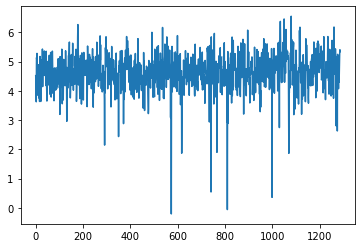

In [179]:
predictions = model.predict(test_inputs, batch_size=256)
plt.plot(predictions.flatten())

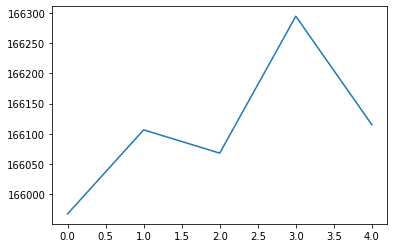

In [36]:
plt.plot(history.history["val_loss"])

In [294]:
print(max(predictions))
print(min(predictions))

[-4.463237]
[-16.249308]


In [295]:
test_labels["pred"] = predictions.flatten()

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [296]:
output_series = test_labels.groupby(test_labels.index).mean()
output_series.columns = ["real_prices", "pred_prices"]

In [297]:
output_series = test_labels.groupby(test_labels.index).mean()
output_series.columns = ["real_diff", "pred_diff"]

In [298]:
start = df_financial.loc["2020-01-01"]["BTC-USD"]
pred_prices =  [start]
for row in output_series.itertuples():
    next_value = pred_prices[-1] + row[2]
    pred_prices.append(next_value)
output_series["pred_prices"] = pred_prices[:-1]

In [ ]:
output_series = test_labels.groupby(test_labels.index).mean()
output_series.columns = ["real_returns", "pred_returns"]

In [219]:
start = df_financial.loc["2020-01-01"]["BTC-USD"]
output_series['real_prices'] = start * (1 + output_series['real_returns']).cumprod()
output_series['pred_prices'] = start * (1 + output_series['pred_returns']/50).cumprod()

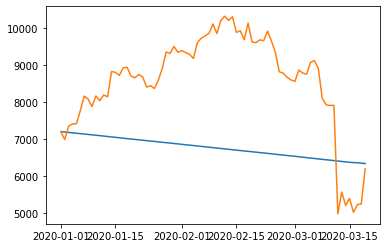

In [299]:
plt.plot(output_series["pred_prices"])
plt.plot(df_financial.loc["2020-01-01":]["BTC-USD"])


In [187]:
min(predictions.flatten())

82.760704

(array([  37.,   65.,  249., 1170., 3320., 1075.,  260.,   97.,   66.,
          22.]),
 array([-0.14085681, -0.10941511, -0.07797342, -0.04653172, -0.01509003,
         0.01635166,  0.04779336,  0.07923505,  0.11067675,  0.14211844,
         0.17356014]),
 <a list of 10 Patch objects>)

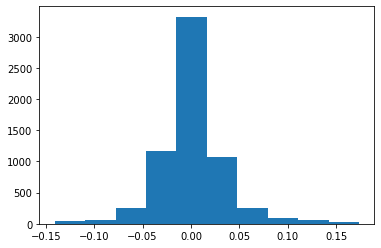

In [148]:
plt.hist(tr_labels["output"],bins = 10)

{'output': array([7200.17431641, 7200.17431641, 7200.17431641, ..., 6191.19287109,
        6191.19287109, 6191.19287109])}

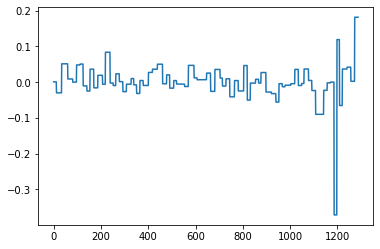

In [80]:
plt.plot(ts_labels["output"])

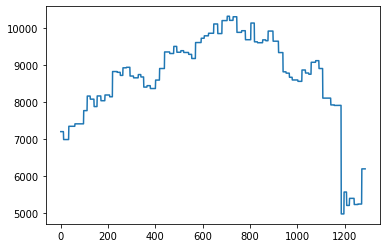

In [48]:
plt.plot(ts_labels["output"])

In [44]:
min(predictions)

array([2234.6895], dtype=float32)

In [152]:
model.save("40_epoch_bert_returns.hdf5")

In [258]:
test_model = build_model(max_seq_length)
test_model.load_weights('one_epoch_bert.hdf5')

In [260]:
test_model.evaluate(test_inputs, ts_labels)

1288/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [261]:
predictions

[0.002772992409574828, 0.0]

In [266]:
predictions = model.predict(test_inputs, batch_size=32)
plt.plot(predictions.flatten())

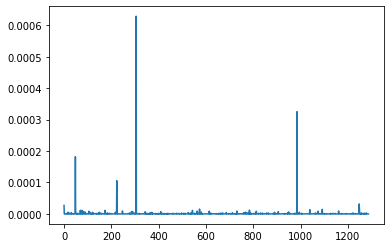

In [268]:
plt.plot(predictions.flatten())

In [272]:
predictions.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [271]:
min(predictions)

array([0.], dtype=float32)

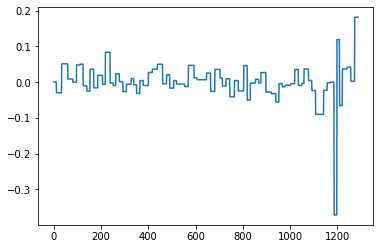

In [270]:
plt.plot(ts_labels["output"])